In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

%matplotlib inline

# standard imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## import data

In [2]:
SSH_test = np.expand_dims(np.load('testAVISO-SSH_2011.npy'),3) 
SSH_test.shape

(365, 240, 280, 1)

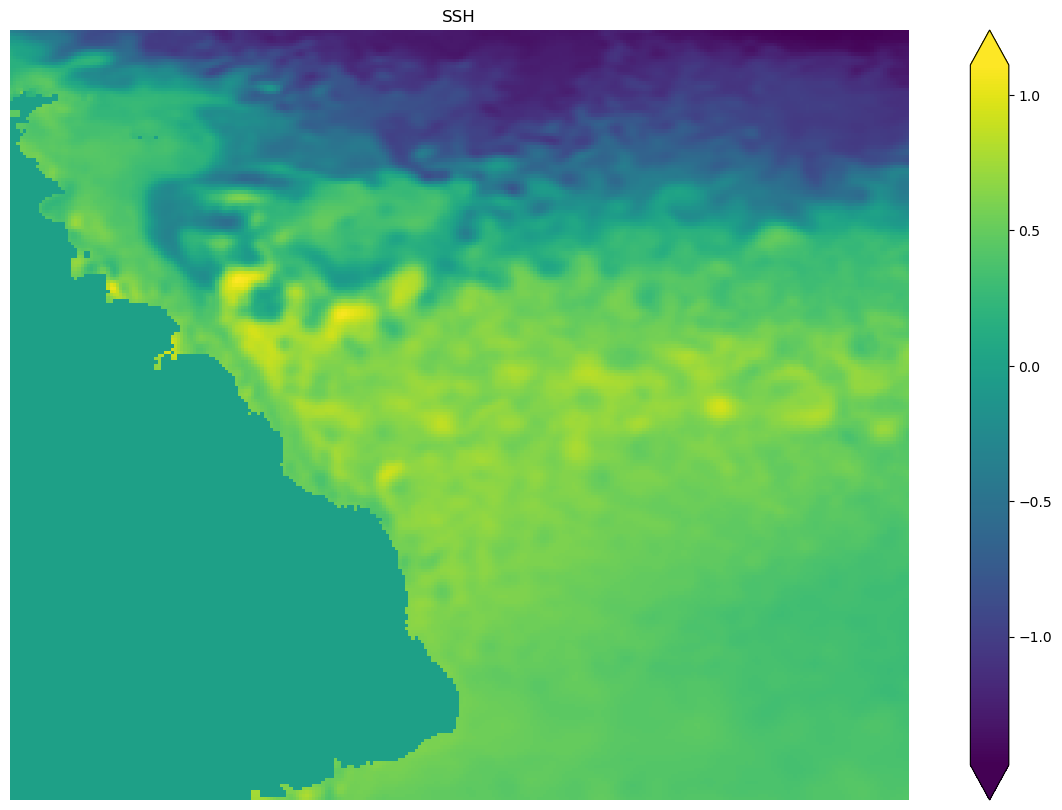

In [3]:
randindex=np.random.randint(0,len(SSH_test))

plt.figure(figsize=(20, 10))
plt.imshow(SSH_test[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('SSH');


## Eddynet 

In [4]:
from keras.models import Model, load_model
from keras.layers import Activation, Reshape, Permute, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization
#from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import SVG 
from keras.utils import model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [5]:
def ConvBNActi(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1
  
def ConvTranspBNActi(nf,ker,inputs):
    conv1 = Conv2DTranspose(nf, ker, strides=(2, 2), padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1

In [6]:
width = 280
height = 240
nbClass = 3
nf = 16
ker = 3

###################################### INPUT LAYER

img_input = Input(shape=(height, width, 1))
######################################ENCODER

conv1 = ConvBNActi(nf,ker,img_input)
conv1 = ConvBNActi(nf,ker,conv1)
conv1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ConvBNActi(nf,ker,pool1)
conv2 = ConvBNActi(nf,ker,conv2)
conv2 = Dropout(0.3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = ConvBNActi(nf,ker,pool2)
conv3 = ConvBNActi(nf,ker,conv3)
conv3 = Dropout(0.4)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#######################################center

convC = ConvBNActi(nf,ker,pool3)
convC = ConvBNActi(nf,ker,convC)
convC = Dropout(0.5)(convC)

#######################################DECODER

#up3 = concatenate([ConvTranspBNActi(nf,ker,convC), conv3])
up3 = concatenate([UpSampling2D((2,2))(convC), conv3])
decod3 = ConvBNActi(nf,ker,up3)
decod3 = ConvBNActi(nf,ker,decod3)
decod3 = Dropout(0.4)(decod3)



#up2 = concatenate([ConvTranspBNActi(nf,ker,decod3), conv2])
up2 = concatenate([UpSampling2D((2,2))(decod3), conv2])
decod2 = ConvBNActi(nf,ker,up2)
decod2 = ConvBNActi(nf,ker,decod2)
decod2 = Dropout(0.3)(decod2)


#up1 = concatenate([ConvTranspBNActi(nf,ker,decod2), conv1])
up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ConvBNActi(nf,ker,up1)
decod1 = ConvBNActi(nf,ker,decod1)
decod1 = Dropout(0.2)(decod1)


####################################### Segmentation Layer

x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
eddynet = Model(img_input, x)

2023-12-30 23:39:14.391266: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-30 23:39:14.391292: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-30 23:39:14.391297: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-30 23:39:14.391346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-30 23:39:14.391364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Load the model's weights

In [7]:
eddynet.load_weights('./weights/eddynetfirst.h5')

## Performance on test dataset (2011 data)

1/1 [==============================] - 0s 282ms/step


2023-12-30 23:39:14.893097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


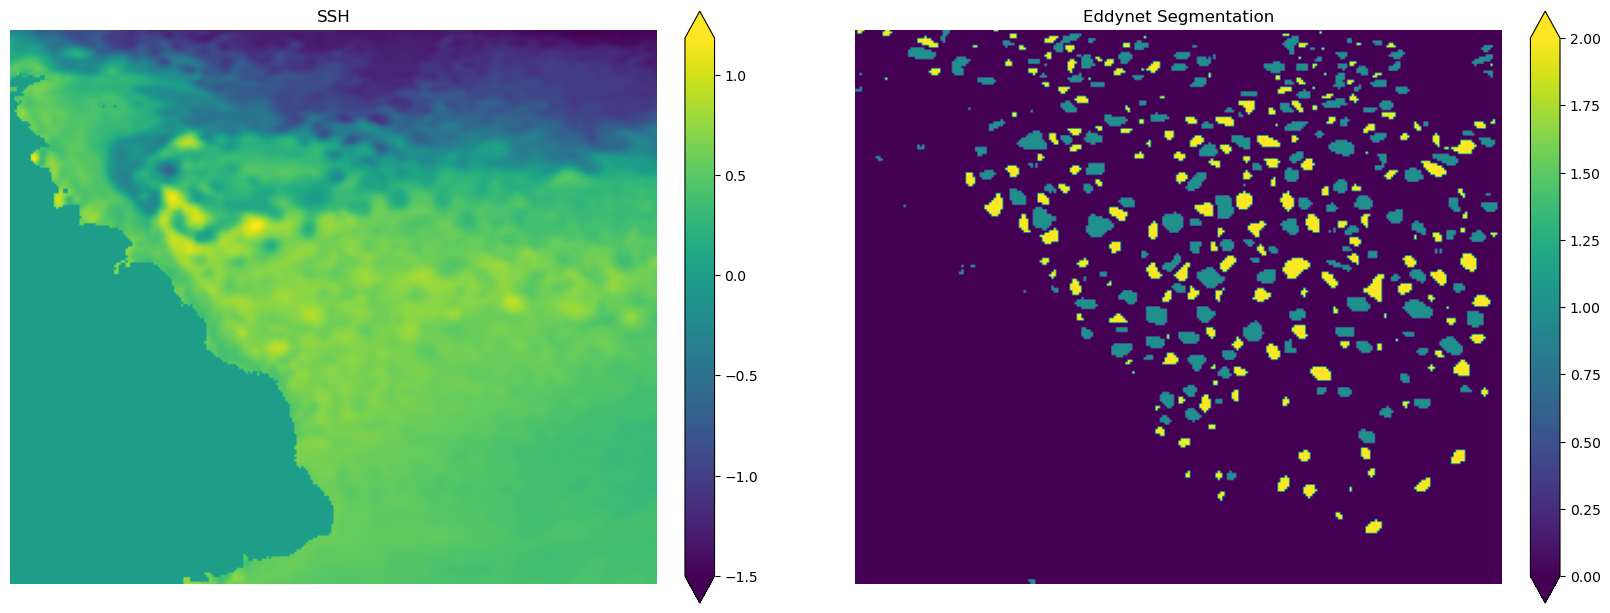

In [8]:
randindex=np.random.randint(0,len(SSH_test))
predictedSEGM=eddynet.predict(np.reshape(SSH_test[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(SSH_test[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(122)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');